In [1]:
!pwd

/home/ashish/Machine-Learning-Practise/Deep Learning Challenge 2


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

In [3]:
from tqdm import tqdm
import os,sys

In [4]:
import cv2
import time

In [5]:
from keras.utils import  to_categorical
from keras_tqdm import TQDMNotebookCallback

/home/ashish/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
# load training and test data csv files
train_data = pd.read_csv('csv/train.csv')
test_data = pd.read_csv('csv/test.csv')

In [7]:
train_data.head()

,row_id,age,gender,view_position,image_name,detected
0,id_0,45,M,0,scan_0000.png,class_3
1,id_1,57,F,0,scan_0001.png,class_3
2,id_10,58,M,0,scan_00010.png,class_3
3,id_1000,64,M,0,scan_0001000.png,class_6
4,id_10000,33,M,1,scan_00010000.png,class_3


In [8]:
test_data.head()

,row_id,age,gender,view_position,image_name
0,id_100,47,M,0,scan_000100.png
1,id_10002,28,M,0,scan_00010002.png
2,id_10005,56,F,0,scan_00010005.png
3,id_10008,41,M,1,scan_00010008.png
4,id_10009,56,F,1,scan_00010009.png


In [9]:
train_data.describe()

,age,view_position
count,18577.000000,18577.000000
mean,47.972601,0.573343
std,16.741076,0.494605
min,2.000000,0.000000
25%,36.000000,0.000000
50%,50.000000,1.000000
75%,60.000000,1.000000
max,414.000000,1.000000


In [10]:
test_data.describe()

,age,view_position
count,12386.000000,12386.000000
mean,48.028984,0.579445
std,16.660680,0.493668
min,1.000000,0.000000
25%,36.000000,0.000000
50%,50.000000,1.000000
75%,60.000000,1.000000
max,152.000000,1.000000


In [11]:
train_data.detected.unique()

array(['class_3', 'class_6', 'class_8', 'class_7', 'class_4', 'class_5',
       'class_10', 'class_11', 'class_1', 'class_12', 'class_13',
       'class_2', 'class_14', 'class_9'], dtype=object)

In [12]:
train_data.detected.nunique()

14

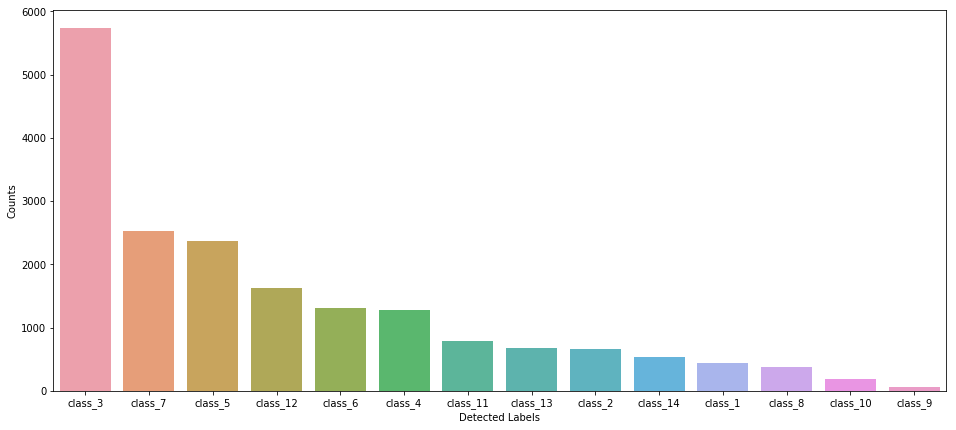

In [13]:
detected_count=train_data.detected.value_counts()
plt.figure(figsize=(16,7))
sns.barplot(x=detected_count.index,y=detected_count.values,alpha=0.9)
plt.xlabel('Detected Labels')
plt.ylabel('Counts')
plt.show()

In [14]:
os.getcwd()

'/home/ashish/Machine-Learning-Practise/Deep Learning Challenge 2'

In [15]:
SOURCE = 'train_'
DEST = 'train128'
IMG_SIZE=128
X_train=[]
def save_images(SOURCE,DEST,IMG_SIZE):
    for img_name in tqdm(train_data['image_name'].values):
        img_path = os.path.join(SOURCE,img_name)
        img=cv2.imread(img_path,cv2.IMREAD_COLOR)
        img=cv2.resize(img,(IMG_SIZE,IMG_SIZE))
        #cv2.imwrite(os.path.join(os.getcwd(),DEST,img_path),img)
        #cv2.waitKey(0)
        #temp_img=image.load_img(img_path)
        X_train.append(img)
        del img
            

In [16]:
save_images(SOURCE,DEST,IMG_SIZE)

100%|██████████| 18577/18577 [04:37<00:00, 66.83it/s]


In [17]:
class_list=train_data['detected'].tolist()
class_dict={name:count+1 for count,name in enumerate(set(class_list))}
y_train = [class_dict[k] for k in class_list]

In [18]:
y_train=np.array(y_train)

In [19]:
from keras import applications
from keras.models import Model
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

### Making  Training Output Labels

In [20]:
y_train = to_categorical(y_train)


In [21]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])

In [22]:
#Transfer learning with VGG16 
model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))


In [25]:
X_train=np.array(X_train,np.float32)/255.0

In [26]:
X_train.shape

(18577, 128, 128, 3)

In [27]:
## set model architechture 
add_model = Sequential()
add_model.add(Flatten(input_shape=model.output_shape[1:]))
add_model.add(Dense(256, activation='relu'))
add_model.add(Dense(y_train.shape[1], activation='softmax'))

model = Model(inputs=model.input, outputs=add_model(model.output))
model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

In [28]:


train_datagen = ImageDataGenerator(
        rotation_range=30, 
        width_shift_range=0.1,
        height_shift_range=0.1, 
        horizontal_flip=True)
train_datagen.fit(X_train)

In [31]:
batch_size = 32 # tune it
epochs = 50 # increase it lb:0.40856(50 epochs), 0.27101 (5 epochs)

history = model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=X_train.shape[0] // batch_size,
    epochs=epochs
)

Epoch 1/50
280/580 [=============>................] - ETA: 10:43:26 - loss: 2.2023 - acc: 0.3079

KeyboardInterrupt: 

In [32]:
del X_train

In [39]:
test_img = []
SOURCE='test_'
def save_images(SOURCE,IMG_SIZE):
    for img_name in tqdm(test_data['image_name'].values):
        img_path = os.path.join(SOURCE,img_name)
        img=cv2.imread(img_path,cv2.IMREAD_COLOR)
        img=cv2.resize(img,(IMG_SIZE,IMG_SIZE))
        #cv2.imwrite(os.path.join(os.getcwd(),DEST,img_path),img)
        #cv2.waitKey(0)
        #temp_img=image.load_img(img_path)
        test_img.append(img)
        del img
            

In [40]:
save_images('test_',128)

100%|██████████| 12386/12386 [04:59<00:00, 41.32it/s]


In [41]:
x_test=np.array(test_img,np.float32)/255.

In [ ]:
x_test.shape

In [ ]:
## predict test data
predictions = model.predict(x_test)